# Laser Pulse Identification in Images

This notebook demonstrates an exploration of machine learning algorithms that can be used to differentitate laser pulses from noise and locate the pulse peaks in images taken from a streak camera. Two approaches are explored:
- A neural network trained to identify the number of laser pulses and their general locations, from which the exact locations of the peaks can be found
- The Laplacian of Gaussian (LoG) "blob detector" algorithm

These algorithms serve as the general proof of concept for a laser pulse detection algorithm to aid in the calibration of specialized cameras.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.neural_network import MLPClassifier
from skimage.feature import blob_log
from PIL import Image
from scipy import stats
from scipy.signal import find_peaks

## Neural Network
An image of laser pulses is split into a training and a test image. Laser pulses in the training image are labeled, and the image is used to train the neural network to detect laser pulses in similar images. The test image is used to test the accuracy of the model's predictions.

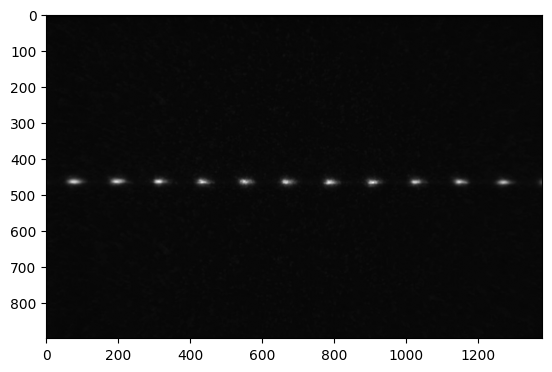

In [2]:
# retrieve the image used for demonstration
pulses = Image.open("laser_pulses.TIF").convert('L')
pulses = np.array(pulses)
# resize
pulses = pulses[:900,:1380]
# convert integer values to floats
pulses = pulses.astype(float)
# plot
plt.imshow(pulses, cmap="grey")

In [3]:
# split data to train model
train = pulses[:,:690]
test = pulses[:,690:]

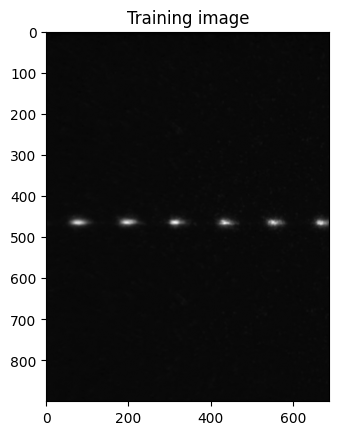

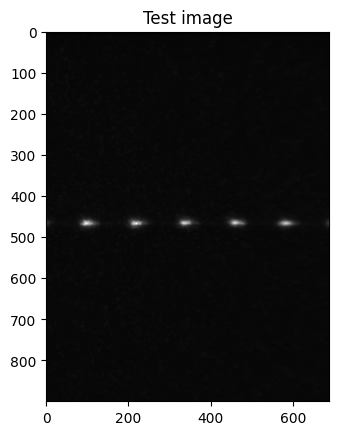

In [4]:
# plot
plt.imshow(train, cmap="grey")
plt.title("Training image")
plt.show()
plt.imshow(test, cmap="grey")
plt.title("Test image")
plt.show()

The images will be split into 30x60 pixel blocks. The blocks that contain pixels will be labeled as such. They will be used to train a neural network classifier to identify laser pulses in an image

In [5]:
# define blocks containing the pulses in training data
pulse1a = train[450:480,30:90]
pulse1b = train[450:480,60:120]
pulse2a = train[450:480,150:210]
pulse2b = train[450:480,180:240]
pulse3a = train[450:480,270:330]
pulse3b = train[450:480,300:360]
pulse4a = train[450:480,390:450]
pulse4b = train[450:480,420:480]
pulse5a = train[450:480,510:570]
pulse5b = train[450:480,540:600]
pulse6 = train[450:480,630:690]

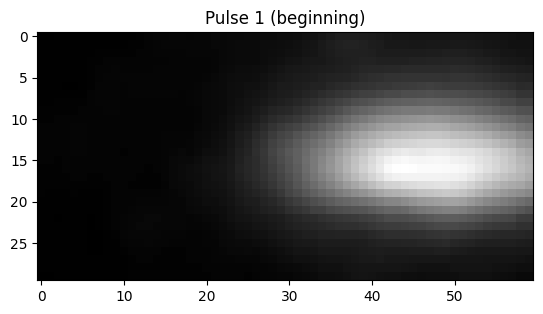

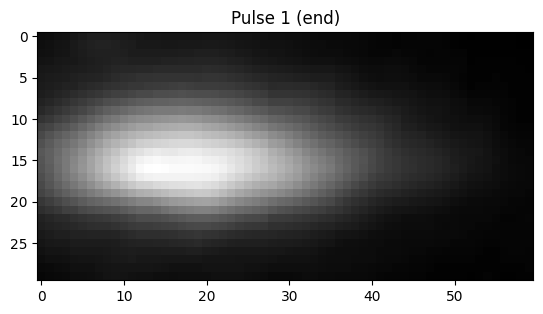

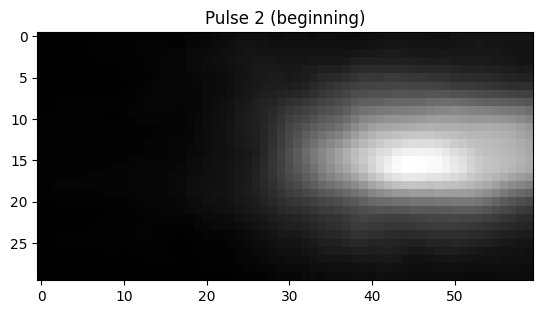

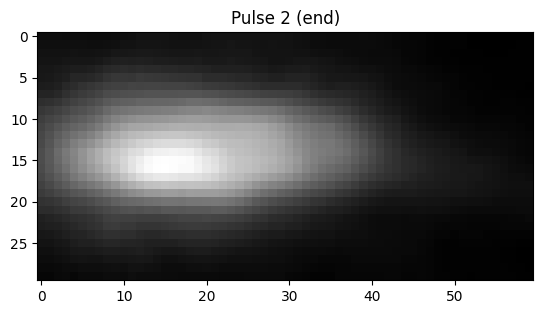

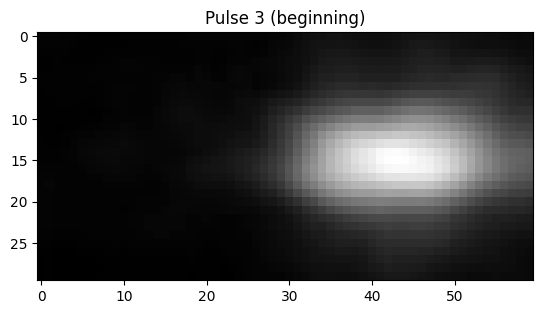

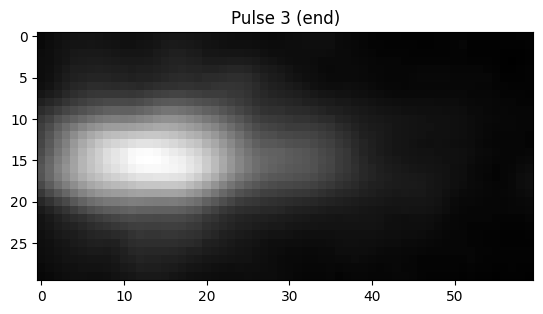

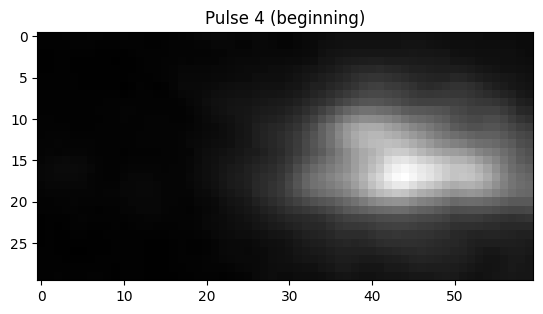

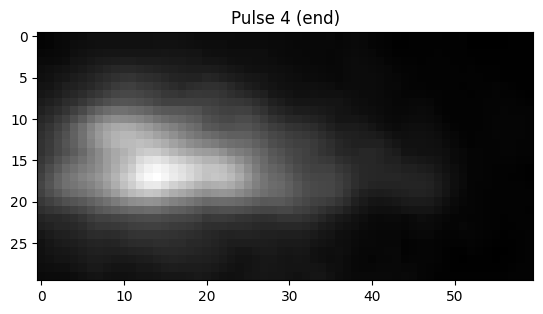

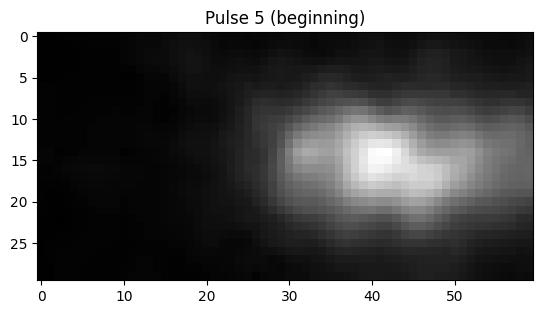

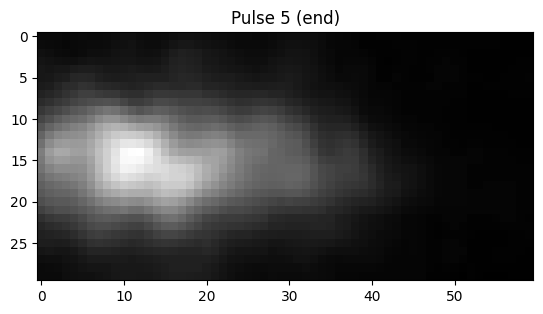

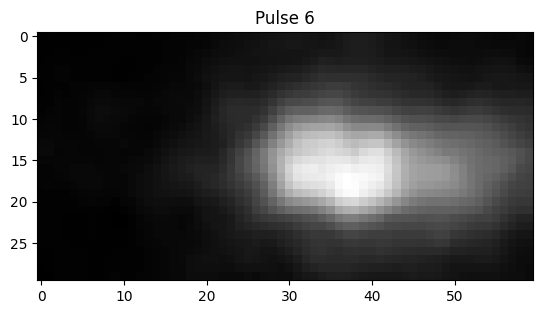

In [6]:
# verify these are the pulses in the image
plt.imshow(pulse1a, cmap="grey")
plt.title("Pulse 1 (beginning)")
plt.show()
plt.imshow(pulse1b, cmap="grey")
plt.title("Pulse 1 (end)")
plt.show()
plt.imshow(pulse2a, cmap="grey")
plt.title("Pulse 2 (beginning)")
plt.show()
plt.imshow(pulse2b, cmap="grey")
plt.title("Pulse 2 (end)")
plt.show()
plt.imshow(pulse3a, cmap="grey")
plt.title("Pulse 3 (beginning)")
plt.show()
plt.imshow(pulse3b, cmap="grey")
plt.title("Pulse 3 (end)")
plt.show()
plt.imshow(pulse4a, cmap="grey")
plt.title("Pulse 4 (beginning)")
plt.show()
plt.imshow(pulse4b, cmap="grey")
plt.title("Pulse 4 (end)")
plt.show()
plt.imshow(pulse5a, cmap="grey")
plt.title("Pulse 5 (beginning)")
plt.show()
plt.imshow(pulse5b, cmap="grey")
plt.title("Pulse 5 (end)")
plt.show()
plt.imshow(pulse6, cmap="grey")
plt.title("Pulse 6")
plt.show()

In [7]:
# record positions of the labeled blocks
pulse_x_labels = [30, 60, 150, 180, 270, 300, 390, 420, 510, 540, 630]

In [8]:
# create an array to store blocks
X_train = []
label = []
# iterate through 30x60 blocks of the image with overlap
for i in range(0, len(train)-15, 15):
    for j in range(0, len(train[0])-30, 30):
        # define the block
        block = train[i:i+30,j:j+60]
        # flatten block and store in array
        X_train.append(np.reshape(block, 1800))
        # label blocks with pulses as '1'
        if i == 450 and j in pulse_x_labels:
            label.append(1)
        # label blocks without pulses as '0'
        else:
            label.append(0)
X_train = np.array(X_train)
label = np.array(label)

In [9]:
# create classifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, activation='relu',
                    hidden_layer_sizes=(5, 5), random_state=1, max_iter=400)
# train model
clf.fit(X_train, label)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 5), max_iter=400,
              random_state=1, solver='lbfgs')

In [10]:
# create test blocks
X_test = []
block_origin = []
# iterate through 30x60 blocks of the image with overlap
for i in range(0, len(train)-15, 15):
    for j in range(0, len(train[0])-30, 30):
        # define the block
        block = test[i:i+30,j:j+60]
        # save the origin point of each block
        block_origin.append([i,j])
        # flatten block and store in array
        X_test.append(np.reshape(block, 1800))
X_test = np.array(X_test)

In [11]:
# predict labels using classifier
test_label = clf.predict(X_test)

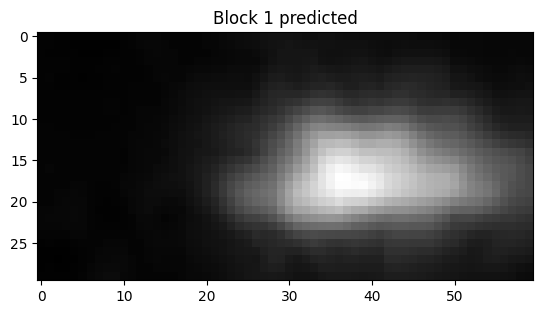

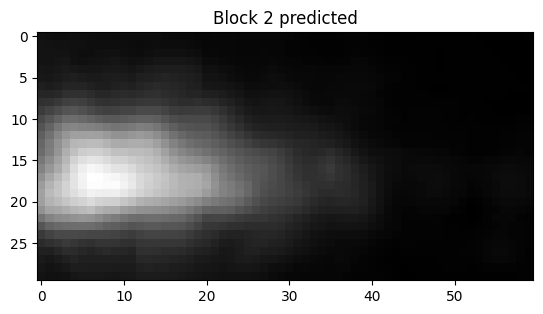

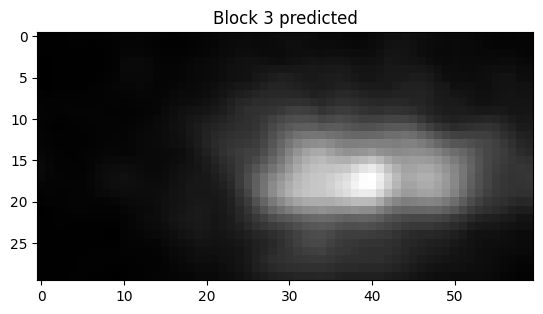

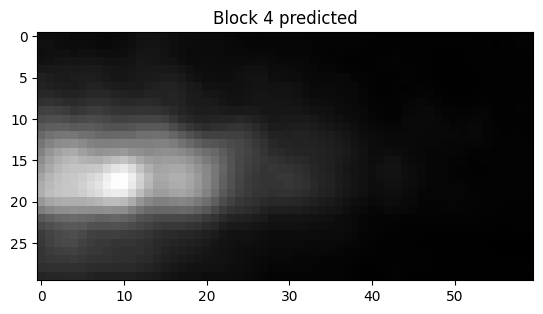

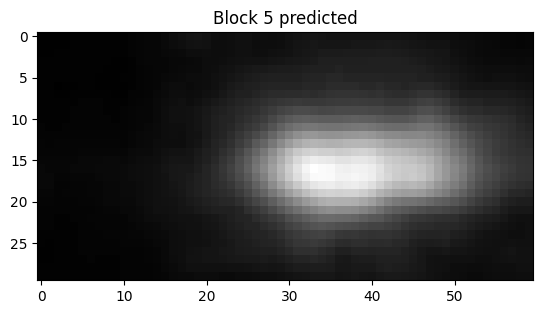

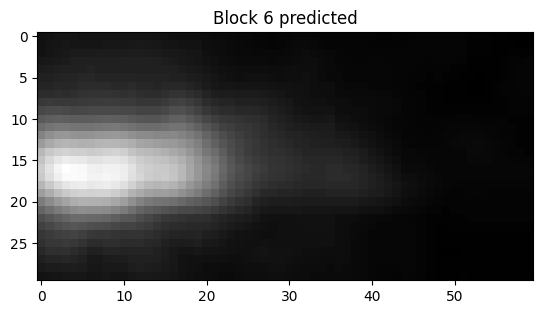

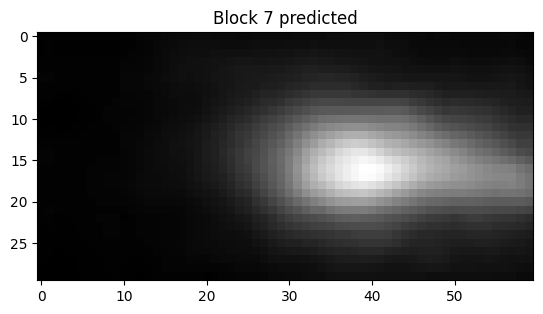

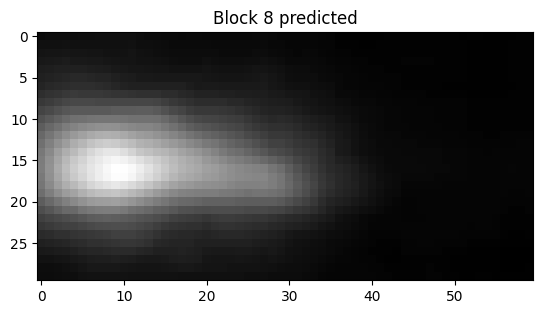

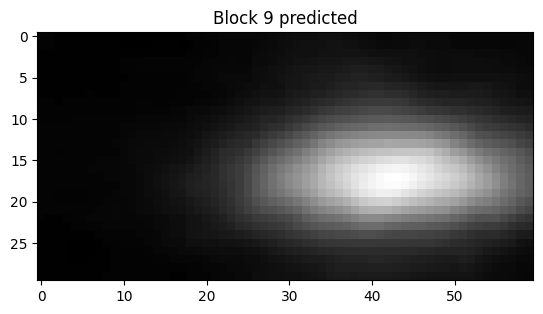

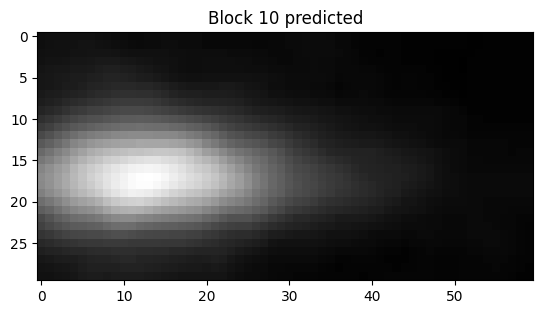

In [12]:
# show pulses predicted from test image
count = 0
for i in range(len(X_test)):
    if test_label[i]:
        count += 1
        plt.imshow(np.reshape(X_test[i], (30,60)), cmap="grey")
        plt.title("Block {} predicted".format(count))
        plt.show()

In [13]:
# find peak of laser pulse
def get_peak(block):
    # find peak values in each line for both x and y directions
    x_peaks = []
    for line in np.reshape(block, (30,60)):
        x_peaks.append(np.argmax(line))
    y_peaks = []
    for line in np.rot90(np.reshape(block, (30,60))):
        y_peaks.append(np.argmax(line))
    # retrieve coordinate of image peak
    x = stats.mode(x_peaks)[0]
    y = stats.mode(y_peaks)[0]
    return [x, y]

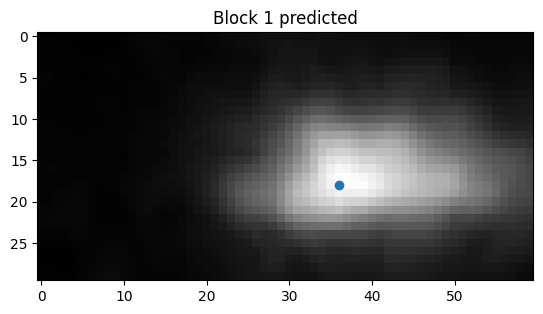

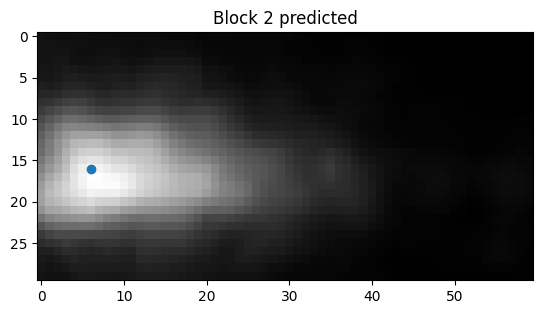

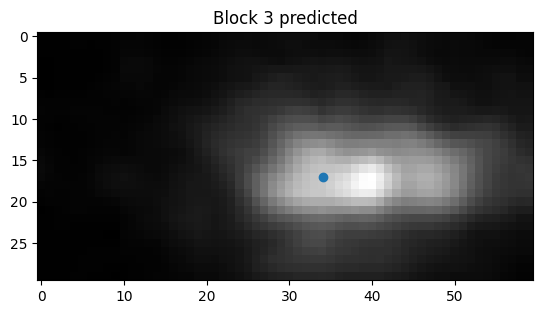

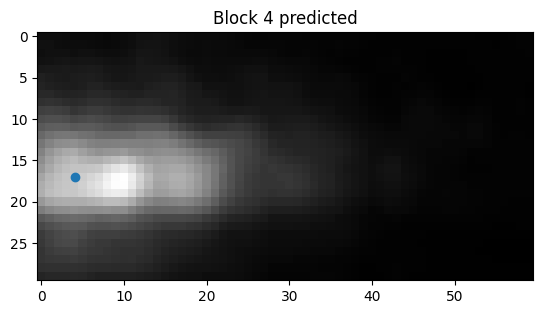

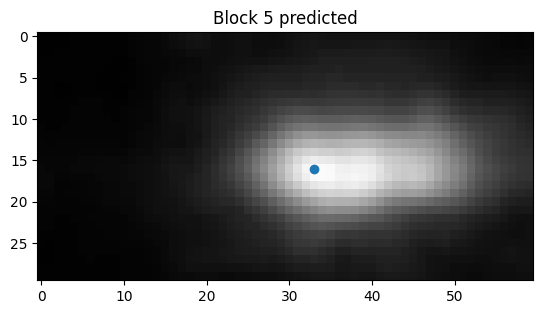

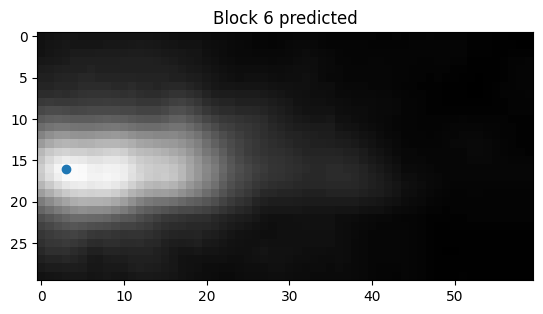

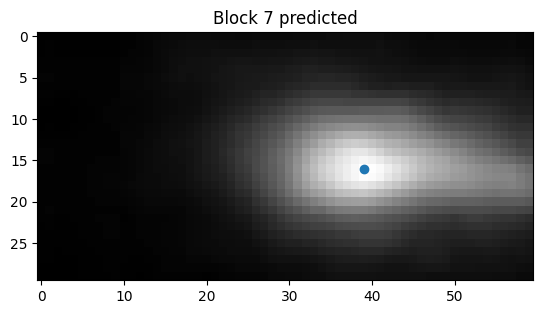

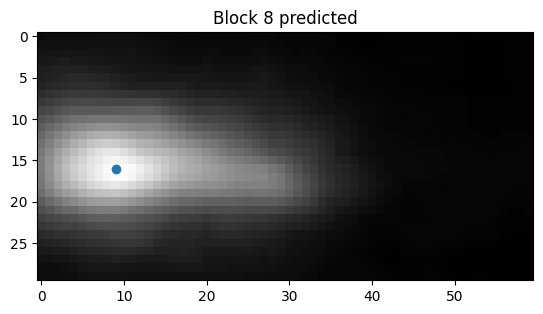

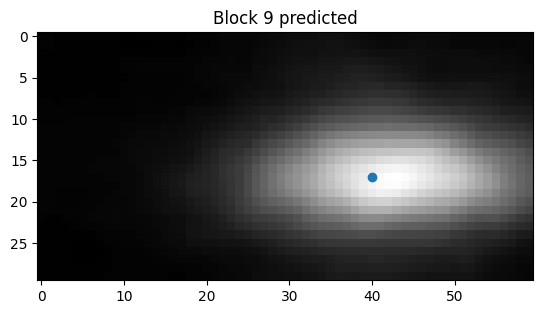

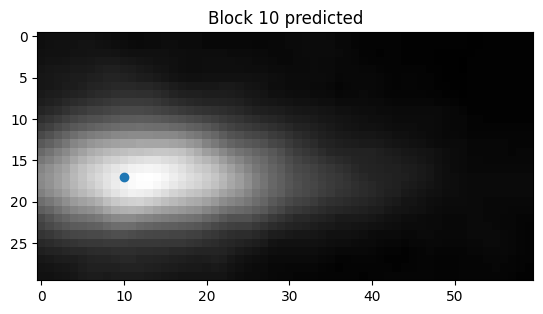

In [14]:
# show pulses predicted from test image
count = 0
for i in range(len(X_test)):
    if test_label[i]:
        count += 1
        plt.imshow(np.reshape(X_test[i], (30,60)), cmap="grey")
        plt.title("Block {} predicted".format(count))
        peak = get_peak(X_test[i])
        plt.scatter(peak[0], peak[1])
        plt.show()

Now that we have shown that we can find the peaks of the laser pulses, we can put them together on the test image.

In [15]:
# find coordinates of predicted pulses and their peaks in the test image
x_peaks = []
y_peaks = []
boxes = []
for i in range(len(X_test)):
    if test_label[i]:
        peak = get_peak(X_test[i])
        x_peaks.append(block_origin[i][1] + peak[0])
        y_peaks.append(block_origin[i][0] + peak[1])
        boxes.append(patches.Rectangle((block_origin[i][1], block_origin[i][0]), 60, 30,
                                       linewidth=1, edgecolor='r', facecolor='none'))

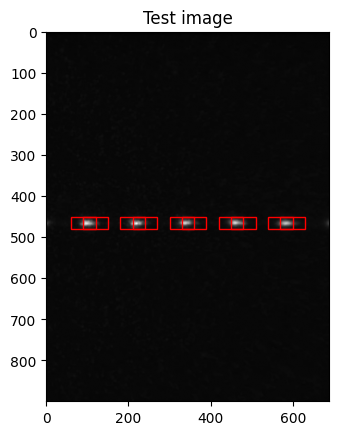

In [16]:
# show prediction of pulses in the test image
fig, ax = plt.subplots()
ax.imshow(test, cmap="grey")

# add boxes to image
for box in boxes:
    ax.add_patch(box)
plt.title("Test image")
plt.show()

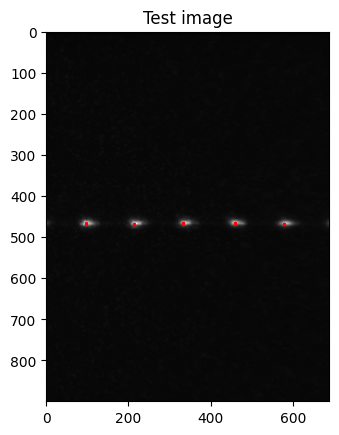

In [17]:
# show pulse peaks derived from predictions
plt.imshow(test, cmap="grey")
plt.title("Test image")
plt.scatter(x_peaks, y_peaks, s=2, c='r')
plt.show()

### Evaluation of Neural Network Approach
**Advantages:**
- Runs quickly once trained

**Disadvantages:**
- Requires extensive labeling
- Only detects region, not peaks

## Laplacian of Gaussian (LoG) Algorithm
An LoG algorithm is used for "blob detection" in images, which is suitable for differentitating laser pulses from noise.

In [18]:
# predict pulses w/ a min standard deviation of 50 for its Gaussian kernel
blobs = blob_log(pulses, min_sigma=50, threshold=0.5)

In [19]:
# find coordinates of predicted pulses in the image
x_peaks = []
y_peaks = []
circles = []
for b in blobs:
    x_peaks.append(b[1])
    y_peaks.append(b[0])
    circles.append(patches.Circle((b[1], b[0]), b[2],
                                 linewidth=1, edgecolor='r', facecolor='none'))

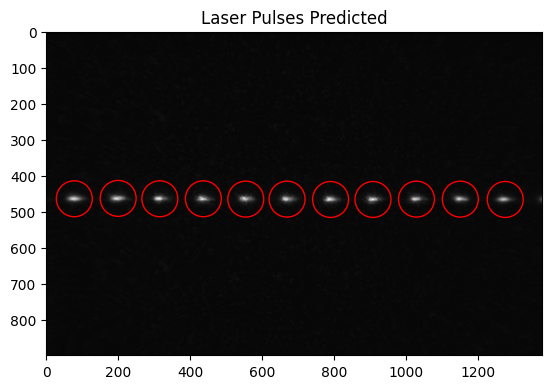

In [20]:
# show pulse predictions
fig, ax = plt.subplots()
ax.imshow(pulses, cmap="grey")
# add circles over predictions
for circle in circles:
    ax.add_patch(circle)
plt.title("Laser Pulses Predicted")
plt.show()

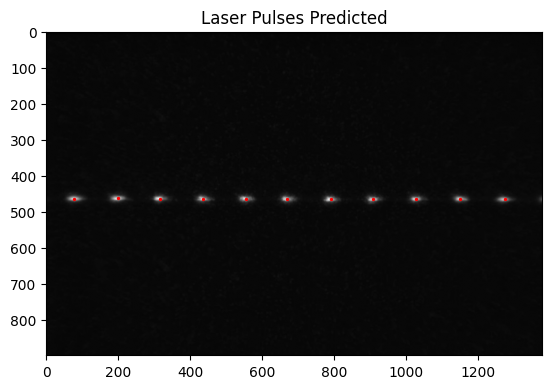

In [21]:
# show pulse peaks derived from predictions
plt.imshow(pulses, cmap="grey")
plt.title("Laser Pulses Predicted")
plt.scatter(x_peaks, y_peaks, s=2, c='r')
plt.show()

### Evaluation of LoG Approach
**Advantages:**
- Runs quickly
- No training or labeling needed

**Disadvantages:**
- Requires extensive labeling
- Only detects region, not peaks

## LoG Algorithm on Real Data
The LoG algorithm does not require training or labeling, which makes it ideal for a quick demonstration on real data.

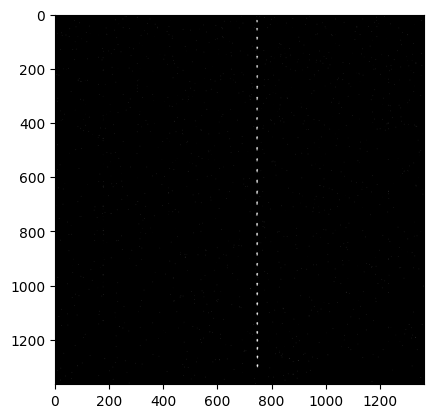

In [22]:
# retrieve a real data image
sweep_40ns = Image.open("40ns_1GHz.TIF").convert('L')
sweep_40ns = np.array(sweep_40ns)
# convert integer values to floats
sweep_40ns = sweep_40ns.astype(float)
# plot
plt.imshow(sweep_40ns, cmap="grey")

The laser pulses captured by the streak cameras are smaller than those in the demo image, so we will need to readjust the parameters. Since the size of the laser pulses are generally uniform for streak camera images (real data), the parameters for the algorithm should not have to be adjusted once set.

In [50]:
# predict pulses w/ a min standard deviation of 20 for its Gaussian kernel
blobs = blob_log(sweep_40ns, min_sigma=15, threshold=2.0)

In [51]:
# find coordinates of predicted pulses in the image
x_peaks = []
y_peaks = []
circles = []
for b in blobs:
    x_peaks.append(b[1])
    y_peaks.append(b[0])
    circles.append(patches.Circle((b[1], b[0]), b[2],
                                 linewidth=1, edgecolor='r', facecolor='none'))

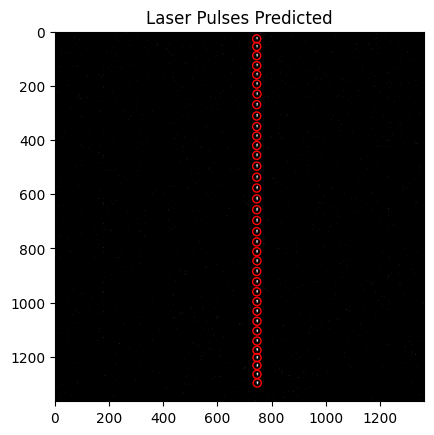

In [52]:
# show pulse predictions
fig, ax = plt.subplots()
ax.imshow(sweep_40ns, cmap="grey")
# add circles over predictions
for circle in circles:
    ax.add_patch(circle)
plt.title("Laser Pulses Predicted")
plt.show()

The parameters for the algorithm were adjusted by trial and error to produce 100% accuracy for this image. To optimize the algorithm for accuracy when applied to swept streak camera images, a mathematical analysis of the algorithm may be necessary.